## Introducción

Para esta primera actividad, se realizó un modelo de Dense Layer con un dataset de 70 mil ejemplos de imágenes de prendas de ropa con el objetivo de que dicho modelo tenga la habilidad de predecir la prenda que contiene cierta imagen. Para esto se explorarán y entenderán los datos para hacer las mejores predicciones posibles, de manera que se hagan las configuraciones correspondientes y se prueben diferentes parámetros.

---

## Exploración, explicación y limpieza de datos

El dataset a utilizar se obtuvo de tensorflow y el cual proviene del paper de Zalando's  sobre imágenes. Este dataset consiste en un conjunto de fotografías de prendas de ropa en blanco y negro. Además, cada imagen es de 28x28 pixeles donde cada pixel tiene asociado un único número que indica la intensidad de la escala de gris. El dataset se encuentra previamente dividido entre train y test, con 60,000 y 10,000 datos respectivamente.  

Cada imagen se asocia a etiquetas que vienen de 10 clases distintas enlistadas a continuación.

| Label | Description   |
|-------|---------------|
| 0     | T-shirt/top   |
| 1     | Trouser       |
| 2     | Pullover      |
| 3     | Dress         |
| 4     | Coat          |
| 5     | Sandal        |
| 6     | Shirt         |
| 7     | Sneaker       |
| 8     | Bag           |
| 9     | Ankle boot    |

Debido a que este dataset se encuentra previamente procesado, no fue necesario realizar una limpieza de los datos ni la transformación de los mismos.

---

## Desarrollo del Modelo de Deep Learning

El modelo desarrollado es una red neuronal profunda (deep learning) que toma como entrada cada imagen aplanada y las pasa a través de una serie de capas ocultas que aplican funciones de activación no lineales, como ReLU o Tanh, para transformar las entradas en características más útiles para la tarea de clasificación. Además, se utilizan capas de Dropout para reducir el riesgo de sobreajuste, y el aprendizaje del modelo es guiado por un optimizador, como Adam o SGD, que ajusta los pesos mediante retropropagación en función de la pérdida calculada con categorical crossentropy. 

Para optimizar el desempeño, se probaron cuatro configuraciones diferentes del modelo, donde varían parámetros clave como el número de capas, las funciones de activación, los inicializadores y los optimizadores. A continuación, se explica qué distingue a cada configuración:

| Configuración | Capas           | Activación | Inicializador    | Optimizer | LR    | Diferencia clave                                                |
|---------------|-----------------|------------|------------------|-----------|-------|-----------------------------------------------------------------|
| 1             | [128, 64]       | ReLU       | He normal        | Adam      | 0.001 | Sencilla, menor capacidad para características complejas.        |
| 2 (Mejor)     | [256, 128, 64]  | ReLU       | Glorot Uniform   | Adam      | 0.001 | Mayor capacidad para aprender patrones complejos.               |
| 3             | [128, 64]       | Tanh       | He normal        | SGD       | 0.01  | Uso de Tanh, menos eficiente en redes profundas.                |
| 4             | [512, 256]      | ReLU       | Glorot Uniform   | Adam      | 0.0005| Más capas grandes, pero con tasa de aprendizaje más baja.        |

Creemos que el modelo 2 es la mejor configuración para el modelo. El modelo 2 se distingue por un balance óptimo entre capacidad y estabilidad en el aprendizaje. Existen varias razones por las que teóricamente podría ser el mejor dado un buen equilibrio entre complejidad y capacidad para extraer características. Otro motivo es el uso de ReLU, función de activación que es conocida por mitigar el problema del desvanecimiento del gradiente, que puede ocurrir en funciones como Tanh (modelo 3). Por último, también creemos que tanto su inicializador Glorot Uniform como su optimizador Adam son buenas elecciones para redes profundas como la que se realiza, ya que permiten una convergencia más rápida y estable.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

Forma del conjunto de entrenamiento: (60000, 28, 28)
Forma del conjunto de prueba: (10000, 28, 28)
Cantidad de instancias de entrenamiento: 60000
Cantidad de instancias de prueba: 10000
Dimensiones de las imágenes: (28, 28)
Tipo de dato de las imágenes: uint8
Tipo de dato de las etiquetas: uint8
Etiquetas únicas en el conjunto de entrenamiento: [0 1 2 3 4 5 6 7 8 9]
Etiquetas únicas en el conjunto de prueba: [0 1 2 3 4 5 6 7 8 9]
Valor mínimo en las imágenes de entrenamiento: 0
Valor máximo en las imágenes de entrenamiento: 255
Valor promedio en las imágenes de entrenamiento: 72.94035223214286


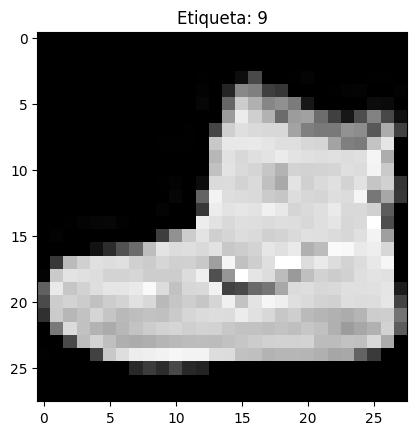

In [2]:
# Paso 1: Cargar y analizar el dataset

# Cargar el dataset Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Revisar la forma del dataset
print(f"Forma del conjunto de entrenamiento: {x_train.shape}")
print(f"Forma del conjunto de prueba: {x_test.shape}")

# Número de columnas e instancias
num_train_samples = x_train.shape[0]
num_test_samples = x_test.shape[0]
image_shape = x_train.shape[1:]  # Dimensiones de las imágenes

print(f"Cantidad de instancias de entrenamiento: {num_train_samples}")
print(f"Cantidad de instancias de prueba: {num_test_samples}")
print(f"Dimensiones de las imágenes: {image_shape}")

# Revisar los tipos de datos
print(f"Tipo de dato de las imágenes: {x_train.dtype}")
print(f"Tipo de dato de las etiquetas: {y_train.dtype}")

# Revisar las etiquetas únicas en el dataset
unique_labels_train = np.unique(y_train)
unique_labels_test = np.unique(y_test)
print(f"Etiquetas únicas en el conjunto de entrenamiento: {unique_labels_train}")
print(f"Etiquetas únicas en el conjunto de prueba: {unique_labels_test}")

# Estadísticas básicas sobre los datos
print(f"Valor mínimo en las imágenes de entrenamiento: {np.min(x_train)}")
print(f"Valor máximo en las imágenes de entrenamiento: {np.max(x_train)}")
print(f"Valor promedio en las imágenes de entrenamiento: {np.mean(x_train)}")

# Ver una muestra del dataset (una imagen y su etiqueta)
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Etiqueta: {y_train[0]}")
plt.show()

In [3]:
# Paso 2: Procesos de limpieza o transformación de los datos

# Normalizar las imágenes (de 0-255 a 0-1)
x_train = x_train / 255.0
x_test = x_test / 255.0

print(f"Valor mínimo después de la normalización: {np.min(x_train)}")
print(f"Valor máximo después de la normalización: {np.max(x_train)}")

# Aplanar las imágenes (28x28 -> 784)
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

print(f"Nuevo tamaño del conjunto de entrenamiento (aplanado): {x_train.shape}")
print(f"Nuevo tamaño del conjunto de prueba (aplanado): {x_test.shape}")

# Convertir las etiquetas a formato categórico (one-hot encoding)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(f"Nuevo formato de las etiquetas (one-hot): {y_train.shape}")

Valor mínimo después de la normalización: 0.0
Valor máximo después de la normalización: 1.0
Nuevo tamaño del conjunto de entrenamiento (aplanado): (60000, 784)
Nuevo tamaño del conjunto de prueba (aplanado): (10000, 784)
Nuevo formato de las etiquetas (one-hot): (60000, 10)



Entrenando modelo con configuración 1: {'layers': [128, 64], 'activation': 'relu', 'dropout_rate': 0.5, 'optimizer': 'adam', 'learning_rate': 0.001, 'initializer': 'he_normal'}
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5407 - loss: 1.2961 - val_accuracy: 0.8127 - val_loss: 0.5203
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7851 - loss: 0.6241 - val_accuracy: 0.8318 - val_loss: 0.4665
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8087 - loss: 0.5550 - val_accuracy: 0.8441 - val_loss: 0.4278
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8235 - loss: 0.5066 - val_accuracy: 0.8504 - val_loss: 0.4234
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8283 - loss: 0.4871 - val_accuracy: 0.8498 - val_loss: 0.4042
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8305 - loss: 0.4873 - val_accuracy: 0.8566 - val_loss: 0.3972
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - 

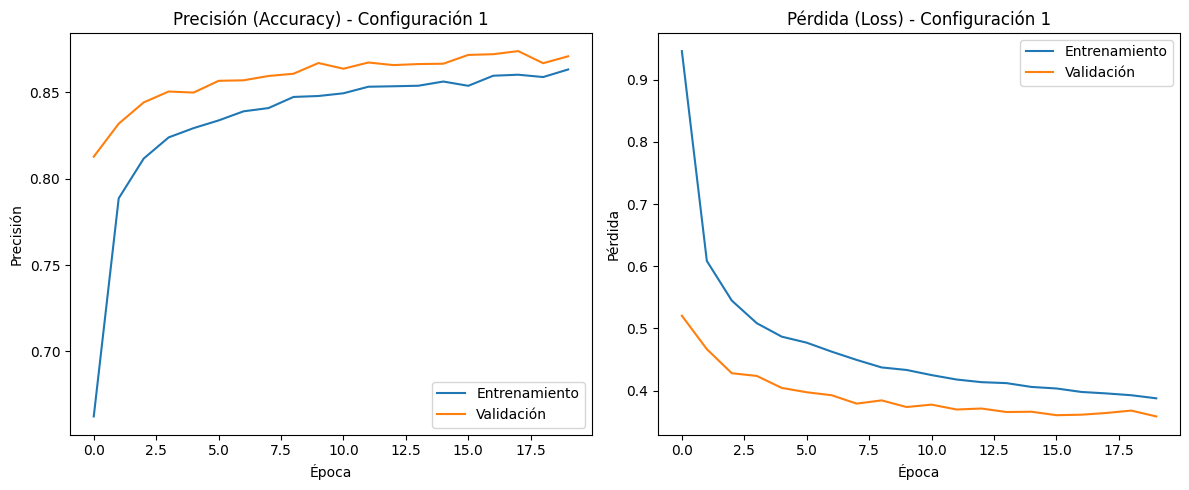

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8730 - loss: 0.3516
Test Accuracy (configuración 1): 87.08%
Test Loss (configuración 1): 0.3582

Entrenando modelo con configuración 2: {'layers': [256, 128, 64], 'activation': 'relu', 'dropout_rate': 0.3, 'optimizer': 'adam', 'learning_rate': 0.001, 'initializer': 'glorot_uniform'}
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6436 - loss: 1.0009 - val_accuracy: 0.8376 - val_loss: 0.4522
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8259 - loss: 0.4938 - val_accuracy: 0.8542 - val_loss: 0.4037
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8464 - loss: 0.4329 - val_accuracy: 0.8593 - val_loss: 0.3910
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8607 - loss: 0.3969 - val_accuracy: 0.8599 - val_loss: 0.3872
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8611 - loss: 0.3934 - val_accuracy: 0.8735 - val_loss: 0.3603
Epoch 6/20
469/469 ━━

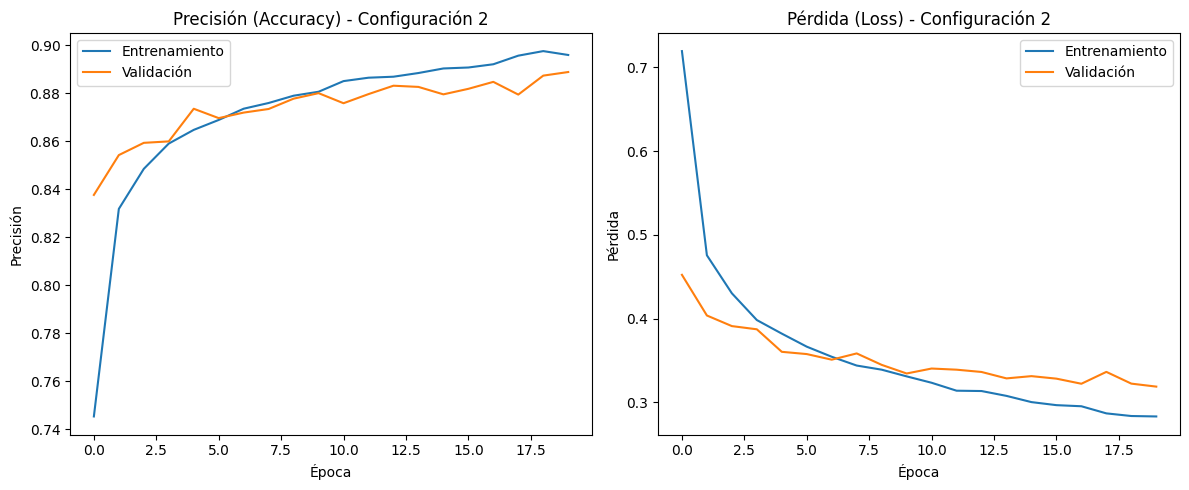

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8904 - loss: 0.3168
Test Accuracy (configuración 2): 88.88%
Test Loss (configuración 2): 0.3188

Entrenando modelo con configuración 3: {'layers': [128, 64], 'activation': 'tanh', 'dropout_rate': 0.5, 'optimizer': 'sgd', 'learning_rate': 0.01, 'initializer': 'he_normal'}
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4064 - loss: 1.7148 - val_accuracy: 0.7478 - val_loss: 0.7119
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6836 - loss: 0.9037 - val_accuracy: 0.7775 - val_loss: 0.6156
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7252 - loss: 0.7917 - val_accuracy: 0.7947 - val_loss: 0.5704
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7527 - loss: 0.7169 - val_accuracy: 0.8074 - val_loss: 0.5417
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7653 - loss: 0.6793 - val_accuracy: 0.8138 - val_loss: 0.5271
Epoch 6/20
469/469 ━━━━━━━━━━━━━━

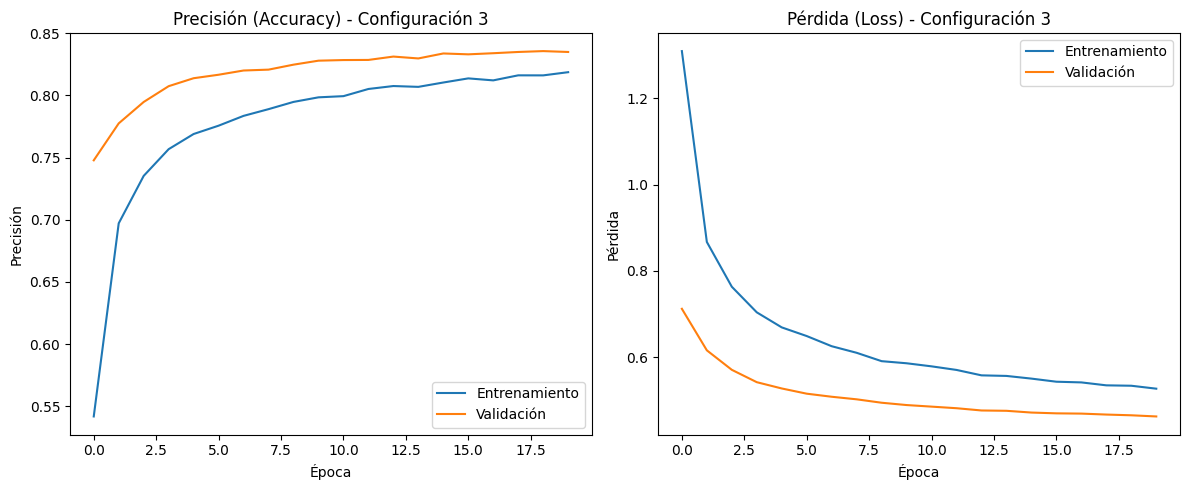

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8383 - loss: 0.4525
Test Accuracy (configuración 3): 83.49%
Test Loss (configuración 3): 0.4622

Entrenando modelo con configuración 4: {'layers': [512, 256], 'activation': 'relu', 'dropout_rate': 0.4, 'optimizer': 'adam', 'learning_rate': 0.0005, 'initializer': 'glorot_uniform'}
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6920 - loss: 0.8697 - val_accuracy: 0.8370 - val_loss: 0.4440
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8375 - loss: 0.4576 - val_accuracy: 0.8474 - val_loss: 0.4204
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8555 - loss: 0.4024 - val_accuracy: 0.8636 - val_loss: 0.3802
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8630 - loss: 0.3795 - val_accuracy: 0.8671 - val_loss: 0.3619
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8703 - loss: 0.3531 - val_accuracy: 0.8760 - val_loss: 0.3498
Epoch 6/20
469/469 ━━━━

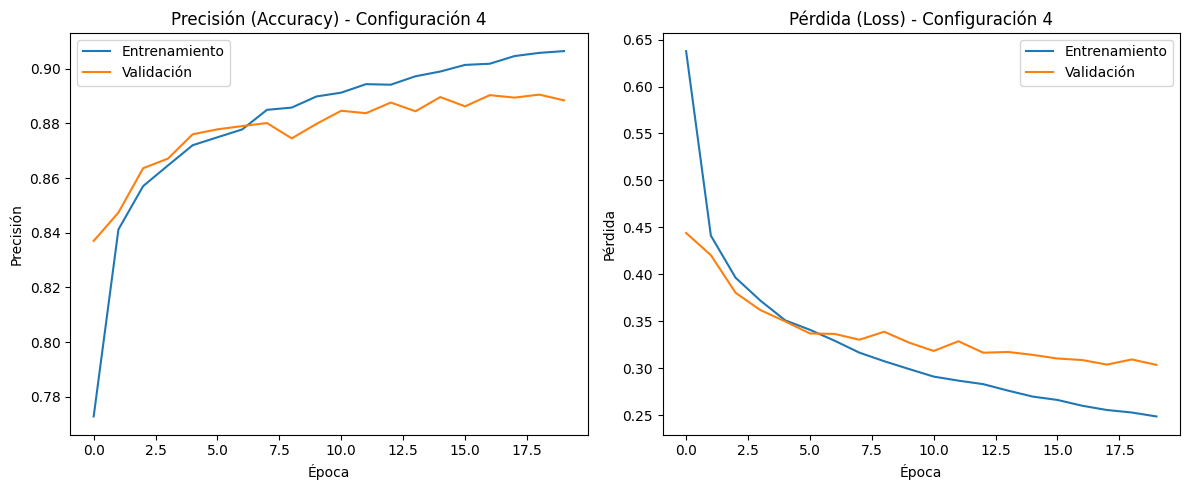

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8917 - loss: 0.3033
Test Accuracy (configuración 4): 88.84%
Test Loss (configuración 4): 0.3035


In [7]:
# Paso 3: Crear y entrenar el modelo

def create_dense_model(input_shape, num_classes, 
                       layers=[128, 64], 
                       activation='relu', 
                       dropout_rate=0.5, 
                       optimizer='adam', 
                       learning_rate=0.001, 
                       loss='categorical_crossentropy',
                       metrics=['accuracy'],
                       initializer='glorot_uniform'):
    model = Sequential()

    # Primera capa oculta con la forma de entrada
    model.add(Dense(layers[0], input_shape=(input_shape,), activation=activation, kernel_initializer=initializer))
    
    # Dropout opcional
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Capas intermedias ocultas
    for units in layers[1:]:
        model.add(Dense(units, activation=activation, kernel_initializer=initializer))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Capa de salida (softmax para clasificación multicategoría)
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=initializer))
    
    # Configurar el optimizador
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    # Compilar el modelo
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

# Parámetros comunes del modelo
input_shape = 28 * 28  # Tamaño de las imágenes aplanadas
num_classes = 10       # 10 categorías de prendas

# Early Stopping: detener si no mejora en 3 épocas consecutivas
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Diferentes configuraciones para probar, incluyendo inicializadores
configurations = [
    {'layers': [128, 64], 'activation': 'relu', 'dropout_rate': 0.5, 'optimizer': 'adam', 'learning_rate': 0.001, 'initializer': 'he_normal'},
    {'layers': [256, 128, 64], 'activation': 'relu', 'dropout_rate': 0.3, 'optimizer': 'adam', 'learning_rate': 0.001, 'initializer': 'glorot_uniform'},
    {'layers': [128, 64], 'activation': 'tanh', 'dropout_rate': 0.5, 'optimizer': 'sgd', 'learning_rate': 0.01, 'initializer': 'he_normal'},
    {'layers': [512, 256], 'activation': 'relu', 'dropout_rate': 0.4, 'optimizer': 'adam', 'learning_rate': 0.0005, 'initializer': 'glorot_uniform'}
]

# Paso 3: Probar múltiples configuraciones
for i, config in enumerate(configurations):
    print(f"\nEntrenando modelo con configuración {i+1}: {config}")
    
    # Crear el modelo con la configuración actual
    model = create_dense_model(input_shape, num_classes, 
                               layers=config['layers'],
                               activation=config['activation'], 
                               dropout_rate=config['dropout_rate'], 
                               optimizer=config['optimizer'], 
                               learning_rate=config['learning_rate'],
                               loss='categorical_crossentropy',
                               metrics=['accuracy'],
                               initializer=config['initializer'])
    
    # Entrenar el modelo con Early Stopping
    history = model.fit(x_train, y_train, 
                        epochs=20, 
                        batch_size=128, 
                        validation_data=(x_test, y_test),
                        #callbacks=[early_stopping],
                        verbose=1)
    
    # Paso 4: Graficar los resultados para cada configuración
    history_df = pd.DataFrame(history.history)
    
    plt.figure(figsize=(12, 5))
    
    # Gráfico de accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Entrenamiento')
    plt.plot(history_df['val_accuracy'], label='Validación')
    plt.title(f'Precisión (Accuracy) - Configuración {i+1}')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    
    # Gráfico de pérdida (loss)
    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Entrenamiento')
    plt.plot(history_df['val_loss'], label='Validación')
    plt.title(f'Pérdida (Loss) - Configuración {i+1}')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    
    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Accuracy (configuración {i+1}): {test_accuracy * 100:.2f}%")
    print(f"Test Loss (configuración {i+1}): {test_loss:.4f}")

In [8]:
# Paso 4: Evaluar el modelo
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8917 - loss: 0.3033
Test Accuracy: 88.84%


In [10]:
# Paso 5: Hacer predicciones en el conjunto de prueba
predictions = model.predict(x_test)

# Convertir las predicciones a labels (la clase con mayor probabilidad)
predicted_labels = np.argmax(predictions, axis=1)

# Convertir los labels reales desde el one-hot encoding a valores enteros
true_labels = np.argmax(y_test, axis=1)

# Diccionario para mapear los labels numéricos a sus categorías de prendas
label_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Mapear las predicciones y los labels reales a sus nombres de categoría
predicted_labels_names = [label_names[label] for label in predicted_labels]
true_labels_names = [label_names[label] for label in true_labels]

# Crear un DataFrame con los nombres de los labels reales y las predicciones
results_df = pd.DataFrame({
    'True Label': true_labels_names,
    'Predicted Label': predicted_labels_names
})

# Mostrar las primeras filas del DataFrame
print(results_df.head())

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
   True Label Predicted Label
0  Ankle boot      Ankle boot
1    Pullover        Pullover
2     Trouser         Trouser
3     Trouser         Trouser
4       Shirt           Shirt


## Resultados e Interpretación

Tras probar las cuatro configuraciones del modelo, obtuvimos los siguientes resultados en el conjunto de prueba:
* Configuración 1: 87.08% de accuracy, pérdida de 0.3582.
* Configuración 2: 88.88% de accuracy, pérdida de 0.3188.
* Configuración 3: 83.49% de accuracy, pérdida de 0.4622.
* Configuración 4: 88.84% de accuracy, pérdida de 0.3035.

La Configuración 2 fue seleccionada como el modelo final debido a su balance entre una alta precisión (88.88%) y una pérdida moderada (0.3188), además de presentar una arquitectura eficiente en términos de capas y unidades. Aunque la Configuración 4 obtuvo una pérdida ligeramente menor (0.3035), la diferencia en precisión fue marginal, lo que no justificó el uso de una arquitectura más compleja y con una tasa de aprendizaje más baja, lo que podría ralentizar la convergencia.

La decisión de utilizar el inicializador Glorot Uniform en la Configuración 2 ayudó a estabilizar el flujo de gradientes, y el uso del optimizador Adam con una tasa de aprendizaje de 0.001 permitió una convergencia rápida y eficiente. Además, la elección de ReLU como función de activación resultó en un mejor rendimiento en comparación con Tanh, que mostró problemas de convergencia en la Configuración 3.

---

## Conclusión

En este notebook, se exploraron múltiples configuraciones de un modelo de deep learning aplicado al dataset Fashion MNIST. Probamos distintas arquitecturas, inicializadores y optimizadores, seleccionando la Configuración 2 como la mejor opción por su alto rendimiento (88.88% de accuracy) y su equilibrio entre simplicidad y efectividad. Se validó la importancia de elegir adecuadamente los hiperparámetros como el inicializador Glorot Uniform y el optimizador Adam, logrando una rápida convergencia y buen desempeño en la tarea de clasificación de imágenes de ropa.
